## This notebook tests experimental features that will likely change.

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


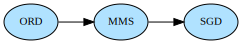

In [1]:
from lale.lib.rasl import OrdinalEncoder as ORD  # TODO: use something convergent instead, maybe SimpleImputer
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    assert final_est in ["sgd", "rfc"]
    return (
        ORD(handle_unknown="use_encoded_value", unknown_value=-1)
        >> MMS()
        >> (SGD(random_state=42) if final_est == "sgd" else RFC(random_state=42))
    )

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, mockup_data_loader, fit_with_batches, cross_val_score

assert is_associative(ORD)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import pandas as pd
from lale.lib.lale import Project, categorical

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns=categorical(10)).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")

pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

unique_class_labels ['good', 'bad']


,class,checking_status,credit_history,purpose,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
993,good,<0,existing paid,furniture/equipment,<100,unemployed,4.0,male single,none,3.0,life insurance,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes
859,good,no checking,existing paid,new car,100<=X<500,1<=X<4,1.0,male single,guarantor,2.0,real estate,none,rent,1.0,skilled,2.0,none,no
298,good,no checking,existing paid,furniture/equipment,<100,1<=X<4,3.0,male single,none,4.0,real estate,none,own,1.0,skilled,1.0,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,bad,0<=X<200,critical/other existing credit,radio/tv,100<=X<500,<1,4.0,male single,none,4.0,no known property,bank,own,2.0,skilled,2.0,none,yes
263,good,no checking,critical/other existing credit,education,<100,>=7,2.0,female div/dep/mar,none,4.0,no known property,bank,for free,3.0,unskilled resident,1.0,none,yes
808,good,0<=X<200,all paid,used car,<100,unemployed,1.0,male single,none,2.0,no known property,bank,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.3%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

majority class 70.909%
accuracy 71.212%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn

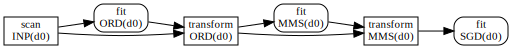

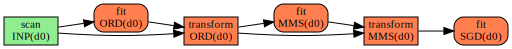

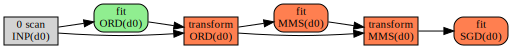

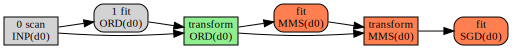

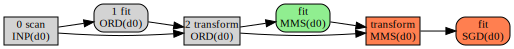

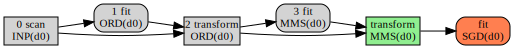

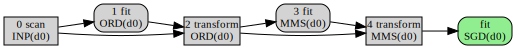

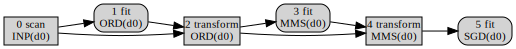

accuracy 71.212%


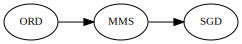

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, unique_class_labels, PrioStep(), incremental=False, verbose=3)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

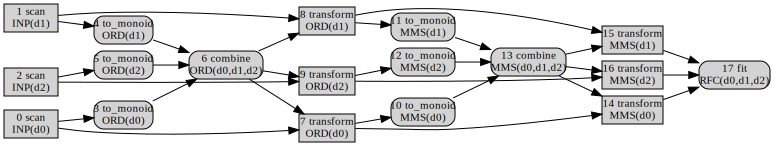

accuracy 73.939%


In [6]:
n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(fresh_pipeline("rfc"), batches, n_batches, unique_class_labels, PrioStep(), incremental=False, verbose=2)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: pre-trained operator

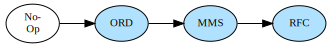

In [7]:
from lale.lib.lale import NoOp

pipeline = NoOp >> fresh_pipeline("rfc")
pipeline.visualize()

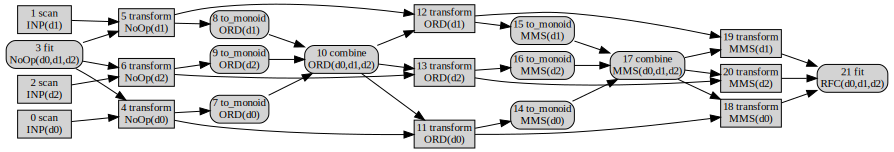

accuracy 73.939%


In [8]:
n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(pipeline, batches, n_batches, unique_class_labels, PrioStep(), incremental=False, verbose=2)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism

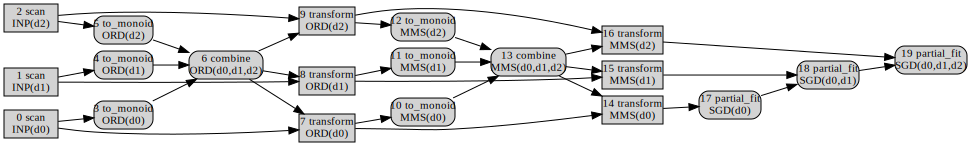

accuracy 69.697%


In [9]:
n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, unique_class_labels, PrioStep(), incremental=False, verbose=2)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

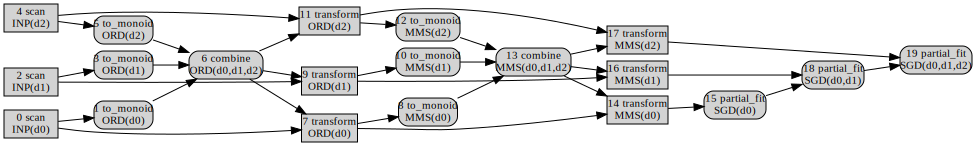

accuracy 69.697%


In [10]:
n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, unique_class_labels, PrioBatch(), incremental=False, verbose=2)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: incremental computation, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

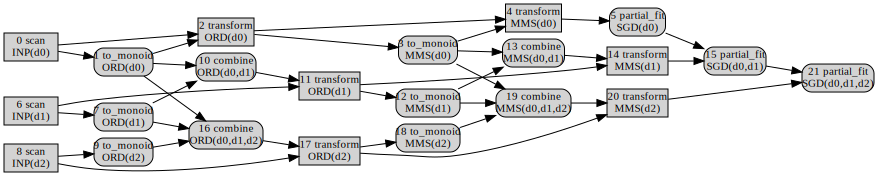

accuracy 69.697%


In [11]:
n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, unique_class_labels, PrioBatch(), incremental=True, verbose=2)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `#~f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

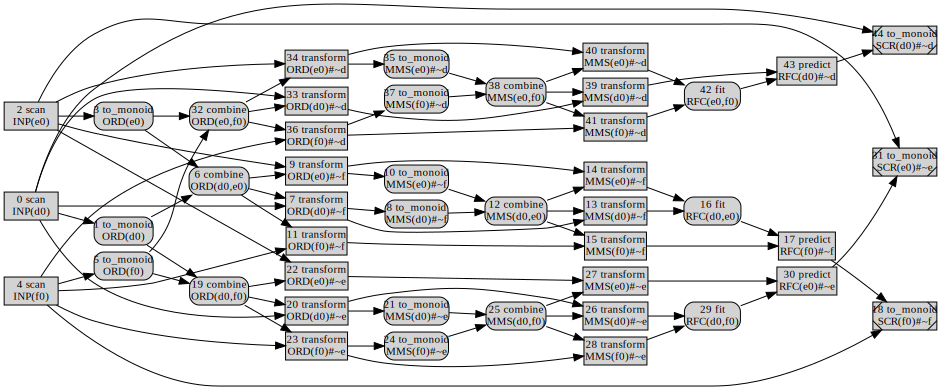

accuracies 73.661%, 73.991%, 72.646%


In [12]:
n_folds, n_batches_per_fold = 3, 1
batches = mockup_data_loader(train_X, train_y, n_folds * n_batches_per_fold)
scores = cross_val_score(fresh_pipeline("rfc"), batches, n_folds * n_batches_per_fold, n_folds, n_batches_per_fold,
                         accuracy_scorer, unique_class_labels, PrioBatch(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

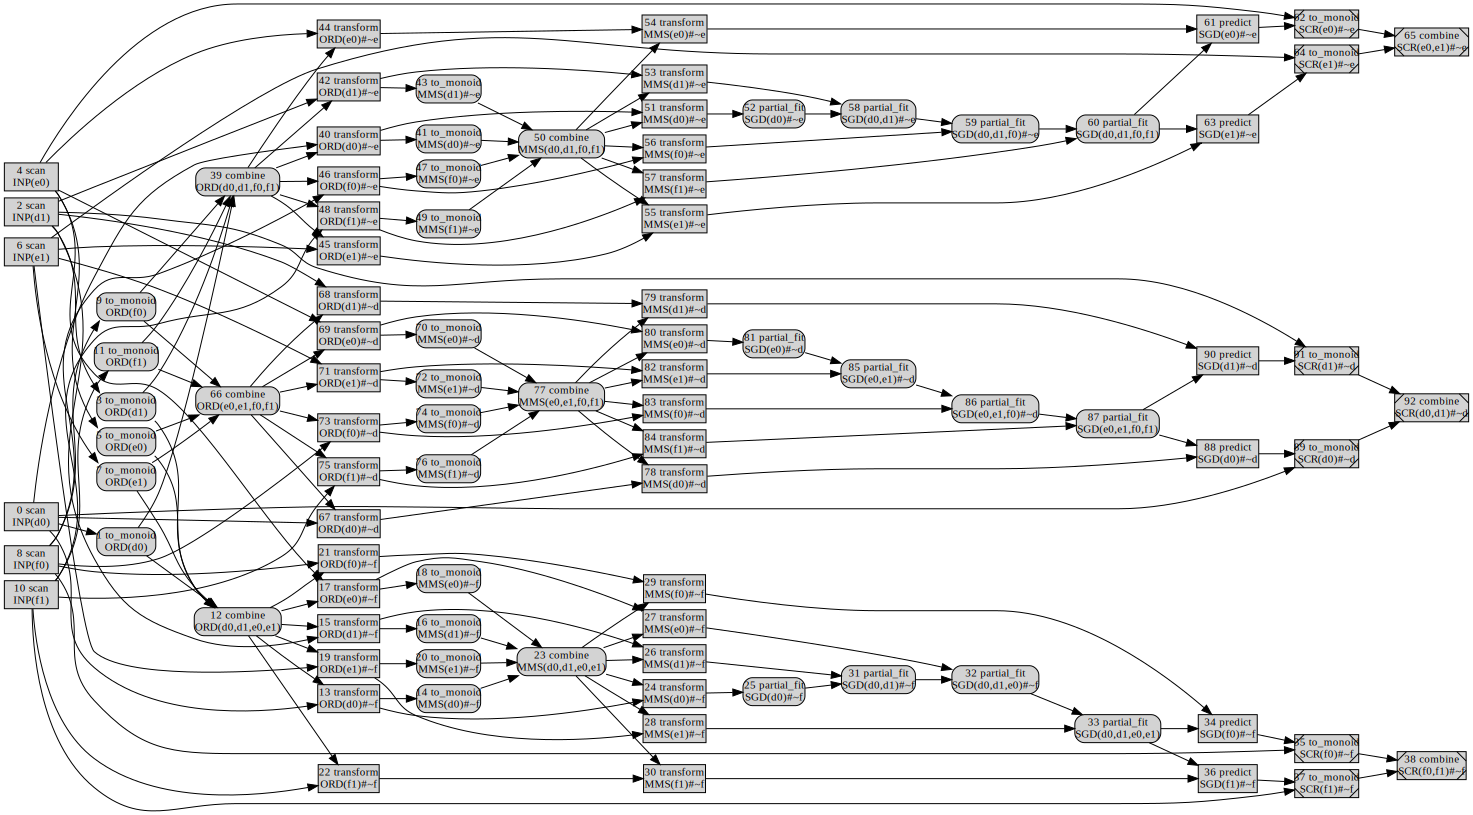

accuracies 69.643%, 68.750%, 52.703%


In [13]:
n_folds, n_batches_per_fold = 3, 2
batches = mockup_data_loader(train_X, train_y, n_folds * n_batches_per_fold)
scores = cross_val_score(fresh_pipeline(), batches, n_folds * n_batches_per_fold, n_folds, n_batches_per_fold,
                         accuracy_scorer, unique_class_labels, PrioBatch(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

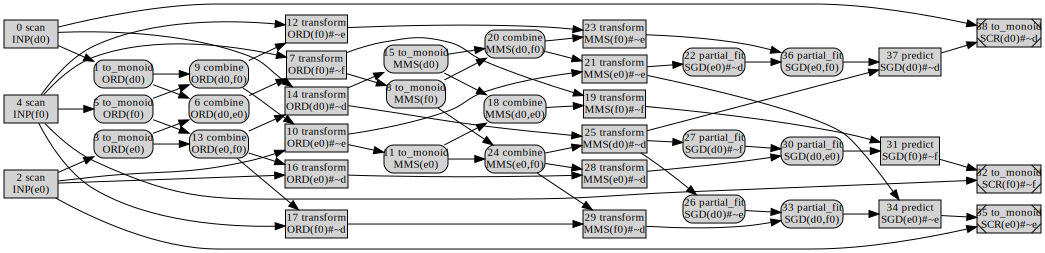

accuracies 70.982%, 66.816%, 69.058%


In [14]:
n_folds, n_batches_per_fold = 3, 1
batches = mockup_data_loader(train_X, train_y, n_folds * n_batches_per_fold)
scores = cross_val_score(fresh_pipeline(), batches, n_folds * n_batches_per_fold, n_folds, n_batches_per_fold,
                         accuracy_scorer, unique_class_labels, PrioBatch(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

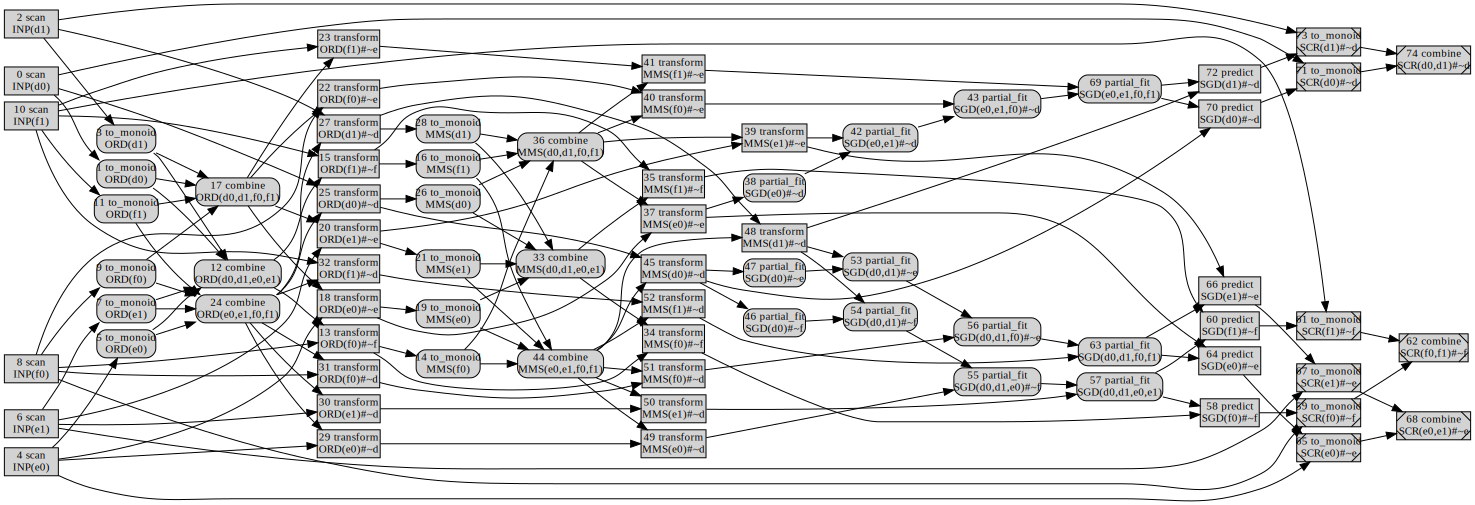

accuracies 69.643%, 69.196%, 49.550%


In [15]:
n_folds, n_batches_per_fold = 3, 2
batches = mockup_data_loader(train_X, train_y, n_folds * n_batches_per_fold)
scores = cross_val_score(fresh_pipeline(), batches, n_folds * n_batches_per_fold, n_folds, n_batches_per_fold,
                         accuracy_scorer, unique_class_labels, PrioBatch(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))